# Two Qubit CNOT Gate with Piccolo.jl

In [1]:
using LinearAlgebra
using Piccolo

## System Hamiltonian

The Hamiltonian for this two qubit system example is given by

$$
H(u(t)) = g \hat a^\dagger \hat a \hat b^\dagger \hat b + a_1(t) (\hat a + \hat a^\dagger) + i a_2(t) (\hat a - \hat a^\dagger) + a_3(t) (\hat b + \hat b^\dagger) + i a_4(t)(\hat b - \hat b^\dagger) 
$$

where $\hat a$ and $\hat b$ are the annihilation operators for the first and second qubit respectively, $g$ is the coupling strength, and $u_i(t)$ are the control functions.


In [2]:
function TwoQubitSystem(levels::Int)

    g_coupling = 0.1 # GHz (linear units)

    # annihilation operator for qubit 1 
    â = QuantumCollocation.lift(annihilate(levels), 1, 2)

    # annihilation operator for qubit 2
    b̂ = QuantumCollocation.lift(annihilate(levels), 2, 2);

    # drift Hamiltonian
    H_drift = 2π * g_coupling * â' * â * b̂' * b̂

    # drive Hamiltonians
    H_drives = [
        2π * (â + â'),
        2π * 1.0im * (â - â'),
        2π * (b̂ + b̂'),
        2π * 1.0im * (b̂ - b̂') 
    ]

    return QuantumSystem(H_drift, H_drives);
end;

In [3]:
levels_per_qubit = 2
system = TwoQubitSystem(levels_per_qubit);

## CNOT Unitary Gate

The goal gate that we will be optimizing for is the CNOT gate defined as

$$
U_{CNOT} = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
$$


In [4]:
U_goal = [
    1 0 0 0;
    0 1 0 0;
    0 0 0 1;
    0 0 1 0
]; 

## Time Discretization Parameters

Here we will define the temporal discretization parameters for the control functions. We will use a total time of $T = 15$ and a time step of $\Delta t = 0.1$.

In [5]:
T = 15.0 # ns
N = 100
Δt = T / N;

## Pulse Constraints

Here we define bounds on the control as well as a constraint on the second derivative of the control that enforces smoothness of the pulse.

In [6]:
a_bound = 0.0175 # GHz
dda_bound = 0.2; # bound on second derivative of control, to ensure smoothness

## Defining The Problem

Here we define the problem using the `UnitarySmoothPulseProblem` which handles setting up a smoothness constrained pulse optimization problem for a unitary gate.

In [7]:
# setting maximum number of iterations 
max_iter = 100 

# TODO: change const violation tolerance
prob = UnitarySmoothPulseProblem(
    system,
    U_goal,
    N,
    Δt;
    a_bound=a_bound,
    dda_bound=dda_bound,
    max_iter=max_iter,
)

applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a


applying constraint: bounds on dda
applying constraint: bounds on Δt
applying constraint: time step all equal constraint


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(46) … MOI.VariableIndex(4411) MOI.VariableIndex(4456); MOI.VariableIndex(2) MOI.VariableIndex(47) … MOI.VariableIndex(4412) MOI.VariableIndex(4457); … ; MOI.VariableIndex(44) MOI.VariableIndex(89) … MOI.VariableIndex(4454) MOI.VariableIndex(4499); MOI.VariableIndex(45) MOI.VariableIndex(90) … MOI.VariableIndex(4455) MOI.VariableIndex(4500)], QuantumSystem{Float64}([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.6283185307179586], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [[0.0 0.0 6.283185307179586 0.0; 0.0 0.0 0.0 6.283185307179586; 6.283185307179586 0.0 0.0 0.0; 0.0 6.283185307179586 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 -0.0 0.0 0.0], [0.0 6.283185307179586 0.0 0.0; 6.283185307179586 0.0 0.0 0.0; 0.0 0.0 0.0 6.283185307179586; 0.0 0.0 6.283185307179586 0.0], [0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 0.0 

Here we plot the initial guess for the unitary and controls, which are stored as `Symbol`s, `:Ũ⃗` and `:a`, respectively. Note that the initial guess for the unitary is not random, it is in fact the geodesic path between the identity and the target unitary. This is not required for the optimizer to converge, but it can help speed up convergence.

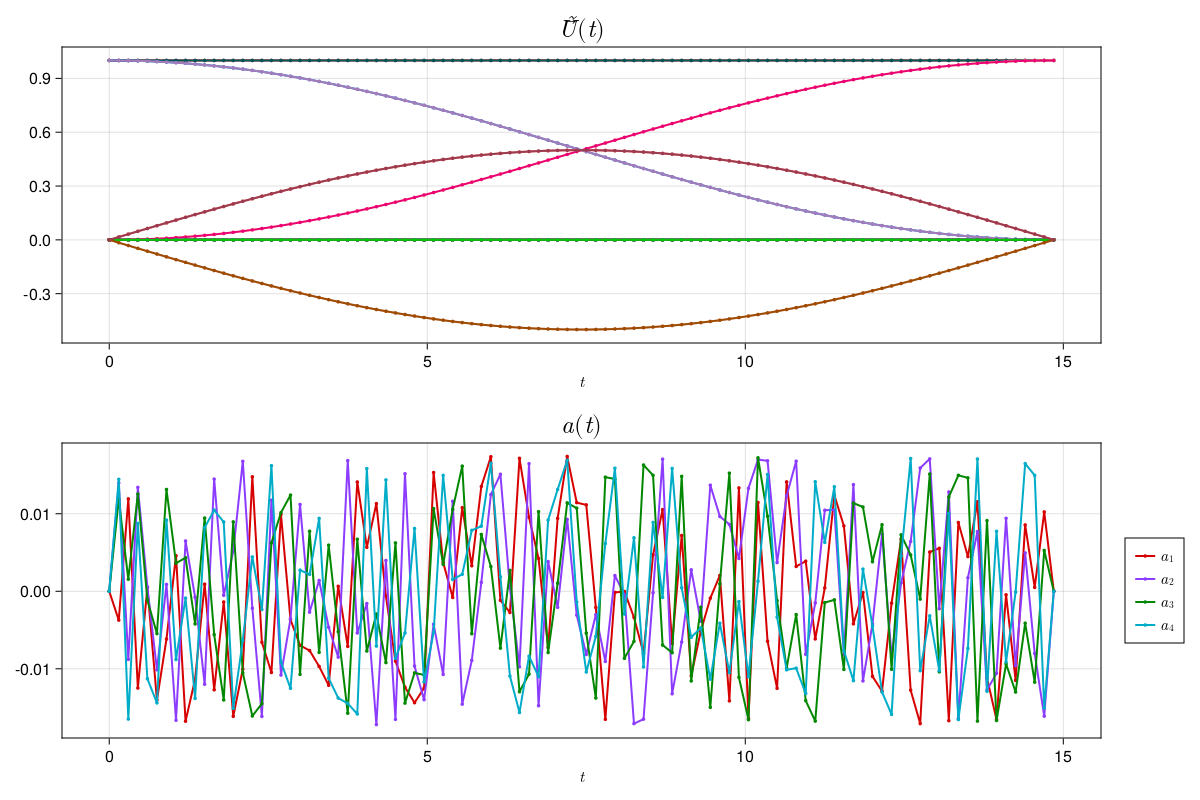

In [8]:
plot(prob.trajectory, [:Ũ⃗, :a]; ignored_labels=[:Ũ⃗])

In [9]:
traj = prob.trajectory
traj.names

(:Ũ⃗, :a, :da, :dda, :Δt)

In [10]:
traj.T * traj.dim

4500

Here we call the `solve!` method on the problem, which uses the interior point nonlinear solver IPOPT to optimize over the states and controls of the problem.

In [12]:
QuantumCollocation.solve!(prob)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    64774
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    34296

Total number of variables............................:     4460
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      892
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4059
Total number of inequality c

   1  5.0477212e+01 3.92e-02 2.50e+01  -1.7 1.76e+00    -  1.00e+00 1.00e+00h  1


   2  1.6908116e+01 3.73e-02 2.61e+01  -1.7 3.07e+01    -  4.57e-02 4.43e-02f  1


   3  1.5236966e+01 2.99e-02 2.98e+01  -1.7 3.22e+00    -  4.87e-02 2.26e-01f  1


   4  3.3702191e+00 2.93e-02 2.34e+01  -1.7 2.64e+00   0.0 1.15e-02 1.09e-01f  1


   5  1.6866861e+01 3.33e-02 2.81e+01  -1.7 5.50e+00  -0.5 2.81e-03 6.22e-02h  1


   6  6.7283395e+00 3.23e-02 2.68e+01  -1.7 2.99e+00  -0.1 5.99e-03 5.31e-02f  1


   7  6.3703832e-01 3.25e-02 2.65e+01  -1.7 7.98e+00  -0.5 4.32e-03 1.27e-02f  1


   8  5.3481069e-01 3.25e-02 2.64e+01  -1.7 1.62e+00  -0.1 4.49e-02 1.60e-03f  1


   9  6.5586567e+00 3.10e-02 2.49e+01  -1.7 2.97e+00  -0.6 1.08e-02 4.53e-02h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2214633e+00 3.10e-02 2.53e+01  -1.7 5.66e+01    -  4.21e-04 3.39e-03f  2


  11  1.5804371e+00 3.07e-02 2.51e+01  -1.7 2.20e+00  -0.2 9.66e-02 1.05e-02f  1


  12  1.3233021e+01 2.72e-02 2.77e+01  -1.7 2.55e+00  -0.6 1.80e-02 1.05e-01h  1


  13  1.1238254e+01 2.58e-02 2.45e+01  -1.7 5.26e+00    -  6.24e-02 7.39e-02f  1


  14  2.5893706e+00 2.51e-02 2.49e+01  -1.7 6.96e+00  -1.1 5.71e-02 2.32e-02f  1


  15  5.2185863e+00 2.34e-02 2.79e+01  -1.7 2.15e+00  -0.7 5.16e-02 7.17e-02h  1


  16  3.2624536e-01 2.33e-02 2.27e+01  -1.7 8.97e+00    -  1.23e-02 9.82e-03f  3


  17  1.7862033e+01 2.30e-02 2.97e+01  -1.7 3.58e+00  -1.2 6.08e-02 9.06e-02h  1


  18  1.0199672e+01 2.27e-02 2.90e+01  -1.7 5.35e+00    -  6.63e-03 2.38e-02f  2


  19  1.5325412e+00 2.26e-02 2.84e+01  -1.7 7.16e+00    -  8.21e-03 1.90e-02f  2


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.4731711e+00 2.25e-02 2.20e+01  -1.7 8.71e+00    -  2.44e-02 1.32e-02h  2


  21  6.6794462e+00 2.07e-02 3.10e+01  -1.7 1.79e+00  -0.7 9.21e-02 1.35e-01h  1


  22  1.4063692e+00 2.06e-02 1.98e+01  -1.7 5.52e+00    -  2.40e-02 2.31e-02f  2


  23  1.4247996e+01 1.98e-02 3.28e+01  -1.7 2.16e+00  -1.2 8.42e-02 1.37e-01h  1


  24  9.1274991e+00 1.97e-02 3.25e+01  -1.7 1.12e+01    -  1.07e-03 8.81e-03f  2


  25  5.1534861e+00 1.97e-02 3.23e+01  -1.7 1.47e+01    -  3.66e-03 6.01e-03f  2


  26  1.2530858e+00 1.96e-02 3.19e+01  -1.7 7.77e+00    -  1.52e-02 1.24e-02f  2


  27  4.4939253e+00 1.93e-02 1.92e+01  -1.7 2.56e+00    -  3.67e-02 4.06e-02h  1


  28  2.7961365e+00 1.91e-02 3.04e+01  -1.7 9.95e+00  -1.7 1.20e-02 4.40e-02f  2


  29  1.2196042e+01 1.83e-02 2.24e+01  -1.7 1.82e+00    -  9.14e-02 1.36e-01h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.6025421e+00 1.55e-02 4.02e+01  -1.7 9.14e-01  -0.4 6.50e-01 1.55e-01f  1


  31  3.9003461e+00 1.07e-02 3.50e+01  -1.7 9.94e-01  -0.8 1.64e-01 3.37e-01f  1


  32  1.9333104e+01 6.35e-03 8.80e+01  -1.7 4.02e-01  -0.4 1.55e-01 8.63e-01h  1


  33  1.8681310e+01 1.85e-03 3.77e+01  -1.7 1.18e-01   0.9 1.00e+00 7.05e-01f  1


  34  1.6402685e+01 3.58e-04 1.37e+01  -1.7 6.47e-02   0.4 6.81e-01 1.00e+00f  1


  35  1.3051028e+01 5.69e-04 6.31e+00  -1.7 1.18e-01  -0.0 6.72e-01 8.98e-01f  1


  36  1.2296392e+01 1.61e-04 1.56e-01  -1.7 6.35e-02   0.4 1.00e+00 1.00e+00f  1


  37  8.7522782e+00 9.59e-04 2.51e+00  -2.5 9.66e-02  -0.1 6.63e-01 1.00e+00f  1


  38  7.5773610e+00 1.63e-04 2.49e-01  -2.5 5.63e-02   0.3 1.00e+00 1.00e+00f  1


  39  6.0627654e+00 5.79e-04 2.60e+00  -2.5 1.30e-01  -0.1 8.23e-01 5.54e-01f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.1114367e+00 1.52e-04 1.17e-01  -2.5 4.59e-02   0.3 1.00e+00 1.00e+00f  1


  41  3.7284428e+00 4.40e-04 1.35e+00  -2.5 9.62e-02  -0.2 8.69e-01 6.32e-01f  1


  42  3.0511220e+00 9.20e-05 1.58e-01  -2.5 4.20e-02   0.2 1.00e+00 1.00e+00f  1


  43  1.5911044e+00 4.48e-04 2.70e-01  -2.5 6.95e-02  -0.2 9.66e-01 1.00e+00f  1


  44  7.7039980e-02 1.30e-03 1.68e+00  -2.5 1.38e-01  -0.7 5.66e-01 8.49e-01f  1


  45  8.4273880e-02 2.55e-03 4.88e+01  -2.5 2.49e-01  -1.2 2.35e-01 4.88e-01f  1


  46  5.8465912e-01 1.99e-03 2.33e+01  -2.5 2.88e-01  -1.7 1.43e-01 4.79e-01H  1


  47  2.6642866e-02 5.60e-04 3.45e+00  -2.5 1.47e-01  -0.3 8.93e-01 9.25e-01f  1


  48  1.2710558e-01 1.23e-03 1.40e+00  -2.5 1.37e-01  -0.8 5.45e-01 6.64e-01f  1


  49  2.0670215e-01 2.74e-04 1.39e+00  -2.5 1.01e-01  -0.4 5.84e-01 1.00e+00f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.3641520e-01 5.20e-04 2.67e-02  -2.5 6.21e-02  -0.9 1.00e+00 1.00e+00h  1


  51  7.2651420e-02 4.32e-04 4.95e+01  -3.8 7.15e-02  -1.3 7.08e-01 1.00e+00h  1


  52  6.0287590e-02 1.56e-03 4.93e+01  -3.8 1.08e-01    -  4.29e-01 9.96e-01h  1


  53  4.1353479e-02 6.76e-04 2.14e+01  -3.8 1.82e-02   0.9 9.18e-01 5.67e-01h  1


  54  2.5246450e-02 4.40e-06 3.21e-01  -3.8 9.54e-03   0.4 9.68e-01 1.00e+00h  1


  55  1.5972897e-02 5.59e-06 6.71e-03  -3.8 7.86e-03  -0.1 1.00e+00 1.00e+00h  1


  56  6.2509282e-03 1.19e-05 2.55e-03  -3.8 8.96e-03  -0.5 1.00e+00 1.00e+00h  1


  57  3.1052350e-03 1.62e-05 1.52e-03  -3.8 1.08e-02  -1.0 1.00e+00 1.00e+00h  1


  58  2.7637271e-03 4.34e-05 1.46e-03  -3.8 2.25e-02  -1.5 1.00e+00 1.00e+00h  1


  59  2.1951285e-03 9.73e-05 4.95e+01  -4.0 3.15e-02  -2.0 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.5723643e-03 1.02e-04 1.24e+01  -4.0 6.53e-02  -2.5 1.00e+00 2.50e-01h  3


  61  2.0140387e-03 1.44e-07 3.20e-02  -4.0 1.47e-03  -0.2 1.00e+00 1.00e+00h  1


  62  1.9117681e-03 3.26e-04 4.95e+01  -4.0 7.00e-02    -  8.30e-01 1.00e+00h  1


  63  1.6857590e-03 3.26e-04 2.62e-02  -4.0 7.19e+00    -  1.65e-02 5.33e-04h  6


  64  2.0559242e-03 8.68e-07 4.95e+01  -4.0 2.97e-03  -0.7 1.00e+00 1.00e+00h  1


  65  2.2949586e-03 1.80e-05 4.95e+01  -4.0 2.81e-02    -  1.00e+00 1.00e+00h  1


  66  2.8079484e-03 1.39e-08 6.66e-02  -4.0 3.50e-04   1.5 1.00e+00 1.00e+00h  1


  67  2.1746703e-03 4.40e-06 4.94e+01  -4.0 9.04e-03    -  1.00e+00 1.00e+00h  1


  68  1.8361083e-03 3.66e-08 4.94e+01  -4.0 5.98e-04   1.1 1.00e+00 1.00e+00h  1


  69  1.8329553e-03 2.24e-09 2.66e-02  -4.0 1.39e-04   1.5 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.8132603e-03 2.91e-09 1.60e-03  -4.0 1.58e-04   1.0 1.00e+00 1.00e+00h  1


  71  1.7943479e-03 3.20e-09 5.65e-04  -4.0 1.68e-04   0.5 1.00e+00 1.00e+00h  1


  72  1.7840545e-03 7.14e-10 9.83e-05  -4.0 8.75e-05   0.1 1.00e+00 1.00e+00h  1


  73  1.7773179e-03 2.85e-10 2.17e-05  -4.0 5.81e-05  -0.4 1.00e+00 1.00e+00h  1


  74  1.7738320e-03 4.19e-13 1.23e-05  -4.0 9.84e-05  -0.9 1.00e+00 1.00e+00H  1


  75  1.7724402e-03 4.29e-09 9.17e-06  -4.0 2.20e-04  -1.4 1.00e+00 1.00e+00h  1


  76  1.7693699e-03 1.92e-08 7.00e-06  -4.0 5.05e-04  -1.9 1.00e+00 1.00e+00h  1


  77  1.7602678e-03 6.54e-08 5.45e-06  -4.0 1.18e-03  -2.3 1.00e+00 1.00e+00h  1


  78  1.7546738e-03 1.16e-07 4.10e-06  -4.0 1.55e-03  -2.8 1.00e+00 1.00e+00h  1


  79  1.7583344e-03 9.53e-08 2.59e-04  -4.0 2.31e-03  -3.3 1.00e+00 2.50e-01h  3


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.7587327e-03 9.32e-08 1.04e-03  -4.0 7.87e-03  -3.8 1.00e+00 3.12e-02h  6


  81  1.7587470e-03 9.32e-08 5.48e-03  -4.0 4.09e-02  -4.2 1.00e+00 9.77e-04h 11


  82  1.7589185e-03 9.21e-08 1.47e-03  -4.0 1.09e-02  -3.8 1.00e+00 1.56e-02h  7


  83  1.7589441e-03 9.20e-08 3.40e-03  -4.0 2.51e-02  -4.3 1.00e+00 1.95e-03h 10


  84  1.7591256e-03 9.09e-08 1.40e-03  -4.0 1.03e-02  -3.9 1.00e+00 1.56e-02h  7


  85  1.7591391e-03 9.09e-08 5.37e-03  -4.0 3.99e-02  -4.3 1.00e+00 9.77e-04h 11


  86  1.7592205e-03 9.03e-08 2.02e-03  -4.0 1.49e-02  -3.9 1.00e+00 7.81e-03h  8


  87  1.7592451e-03 9.02e-08 3.84e-03  -4.0 2.83e-02  -4.4 1.00e+00 1.95e-03h 10


  88  1.7593322e-03 8.97e-08 1.84e-03  -4.0 1.36e-02  -4.0 1.00e+00 7.81e-03h  8


  89  1.8053839e-03 1.73e-04 4.31e-03  -4.0 4.77e-02  -4.4 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.7108139e-03 1.10e-03 4.94e+01  -4.0 1.23e-01  -4.9 9.67e-01 9.31e-01w  1


  91  1.1926611e-01 1.21e-03 8.84e-01  -4.0 4.25e+00    -  1.80e-02 1.79e-02w  1


  92  1.7593454e-03 8.96e-08 6.43e-03  -4.0 4.05e-02  -1.8 1.00e+00 9.77e-04h 10


  93  1.7701837e-03 3.95e-09 1.25e-06  -4.0 2.32e-04  -2.3 1.00e+00 1.00e+00h  1


  94  1.7697021e-03 3.45e-08 1.31e-06  -4.0 6.69e-04  -2.7 1.00e+00 1.00e+00h  1


  95  1.7698328e-03 3.51e-08 2.46e-04  -4.0 2.04e-03  -3.2 1.00e+00 1.25e-01h  4


  96  1.7698540e-03 3.54e-08 9.05e-04  -4.0 6.83e-03  -3.7 1.00e+00 1.56e-02h  7


  97  1.7698646e-03 3.64e-08 4.08e-03  -4.0 3.06e-02  -4.2 1.00e+00 3.91e-03h  9


  98  1.7698685e-03 3.64e-08 1.15e-03  -4.0 8.52e-03  -3.7 1.00e+00 7.81e-03h  8


  99  1.7698729e-03 3.65e-08 3.54e-03  -4.0 2.64e-02  -4.2 1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7698778e-03 3.66e-08 1.27e-03  -4.0 9.41e-03  -3.8 1.00e+00 7.81e-03h  8



Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   1.7698778271753725e-03    1.7698778271753725e-03
Dual infeasibility......:   1.2690288176844008e-03    1.2690288176844008e-03
Constraint violation....:   3.6623520858342085e-08    3.6623520858342085e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0894645012757727e-04    1.0894645012757727e-04
Overall NLP error.......:   1.2690288176844008e-03    1.2690288176844008e-03


Number of objective function evaluations             = 274
Number of objective gradient evaluations             = 101
Number of equality constraint evaluations            = 274
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 101
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 100
Total seconds in IPOPT  

Let's now calculate the fidelity of the optimized unitary with the target unitary, via rollout with the full matrix exponential, this is achieved via the `unitary_fidelity` method.

In [13]:
fid = unitary_fidelity(prob.trajectory, system)
println("Fidelity: $fid")

Fidelity: 0.9999981933046873


In [14]:
unitary_fidelity(prob.trajectory[end].Ũ⃗, prob.trajectory.goal.Ũ⃗)

0.9999982000489841

And now let's plot the final solution for the unitary and controls.

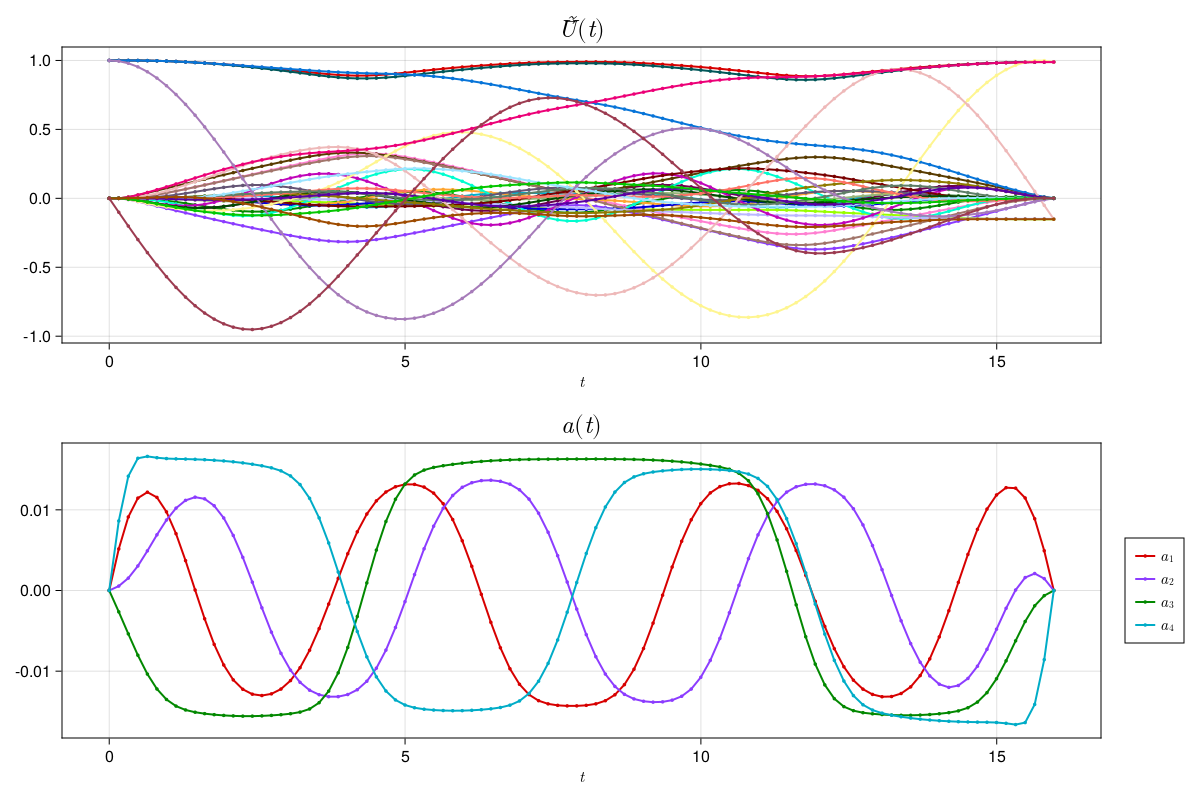

In [15]:
plot(prob.trajectory, [:Ũ⃗, :a]; ignored_labels=[:Ũ⃗])

## Minimum Time CNOT

Now let's see how fast we can make this pulse, by setting up and solving a minimum time problem, using the solution we just found.

We will add an objective term to the problem that penalizes the total time, as well as constraint on the final state of the form

$$
\mathcal{F}(U(T)) \geq \mathcal{F}_{\text{target}}.
$$

This enforce that the final fidelity does not decrease below the threshold $\mathcal{F}_{\text{target}}$, while also allowing the phase to shift.

In [22]:
# final fidelity constraint
min_fidelity = 0.9999

# minimum time objective weight
D = 1000.0

# define the problem
mintime_prob = UnitaryMinimumTimeProblem(prob; D=D, final_fidelity=min_fidelity);

applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
applying constraint: time step all equal constraint


In [17]:
# solving the problem
QuantumCollocation.solve!(mintime_prob; max_iter=max_iter)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    64774
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:    34332

Total number of variables............................:     4460
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      892
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4059
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6125671e+02 3.66e-08 5.12e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  1.4886579e+02 1.14e-02 5.05e+00  -1.7 9.25e-01    -  9.53e-01 9.01e-01f  1


   2  1.4186314e+02 5.20e-03 2.11e+00  -1.7 6.94e-01    -  1.00e+00 1.00e+00h  1


   3  1.4817989e+02 1.95e-03 5.31e+00  -1.7 3.91e-01    -  1.00e+00 6.92e-01h  1


   4  1.5295474e+02 1.44e-03 5.69e+00  -1.7 2.12e-01    -  1.00e+00 1.00e+00h  1


   5  1.5172132e+02 7.16e-04 5.69e+01  -1.7 1.31e-01    -  8.48e-01 4.76e-01h  1


   6  1.5313389e+02 7.18e-04 1.12e+01  -1.7 7.73e-02    -  1.00e+00 1.00e+00h  1


   7  1.5300285e+02 6.93e-04 2.83e+02  -1.7 3.49e-01  -2.0 5.87e-01 6.60e-02h  4


   8  1.5293885e+02 5.92e-04 4.10e+02  -1.7 1.59e-01  -1.6 1.00e+00 2.46e-01h  3


   9  1.5331841e+02 4.89e-04 4.11e+02  -1.7 1.22e-01    -  1.00e+00 2.50e-01h  3


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5414999e+02 2.96e-04 2.91e+02  -1.7 5.82e-02  -1.1 1.00e+00 5.00e-01h  2


  11  1.5426852e+02 2.91e-04 4.01e+02  -1.7 3.29e-01  -1.6 5.14e-01 2.80e-02h  5


  12  1.5467595e+02 2.35e-04 4.39e+02  -1.7 8.22e-02  -1.2 1.00e+00 2.50e-01h  3


  13  1.5605882e+02 6.82e-05 1.13e+01  -1.7 3.79e-02  -0.8 1.00e+00 1.00e+00h  1


  14  1.5615535e+02 4.52e-05 2.44e+02  -1.7 3.86e-02  -1.3 1.00e+00 5.00e-01h  2


  15  1.5704845e+02 2.87e-05 7.62e+00  -1.7 1.90e-02  -1.7 1.00e+00 1.00e+00h  1


  16  1.5691458e+02 1.43e-05 4.99e+00  -1.7 1.39e-02    -  1.00e+00 1.00e+00h  1


  17  1.5716260e+02 1.68e-06 4.58e-01  -1.7 4.94e-03    -  1.00e+00 1.00e+00h  1


  18  1.5716216e+02 1.66e-06 1.74e+01  -1.7 3.98e-02    -  1.00e+00 1.56e-02h  7


  19  1.5714619e+02 1.89e-06 2.27e+01  -1.7 2.70e-02  -2.2 1.00e+00 1.25e-01h  4


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.5710862e+02 2.05e-06 9.41e-02  -1.7 5.05e-03    -  1.00e+00 1.00e+00h  1


  21  1.5459285e+02 1.42e-04 2.78e+02  -2.5 4.13e-02    -  8.61e-01 1.00e+00f  1


  22  1.5398434e+02 2.64e-05 5.61e+00  -2.5 1.58e-02   0.0 1.00e+00 1.00e+00h  1


  23  1.5277161e+02 4.94e-05 5.01e+00  -2.5 2.83e-02  -0.4 1.00e+00 1.00e+00h  1


  24  1.5157239e+02 2.39e-04 4.05e+00  -2.5 6.04e-02  -0.9 1.00e+00 1.00e+00h  1


  25  1.5091002e+02 2.88e-04 4.23e+02  -2.5 1.91e-01  -1.4 1.00e+00 1.94e-01h  2


  26  1.4983218e+02 1.69e-04 2.96e+00  -2.5 3.83e-02    -  1.00e+00 1.00e+00h  1


  27  1.4999321e+02 6.52e-05 5.00e+00  -2.5 2.10e-02    -  1.00e+00 1.00e+00h  1


  28  1.5001883e+02 3.89e-06 5.86e-02  -2.5 7.20e-03    -  1.00e+00 1.00e+00h  1


  29  1.5001352e+02 2.24e-07 5.01e-03  -2.5 1.76e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4879231e+02 8.74e-05 1.75e+01  -3.8 6.87e-02    -  5.56e-01 4.99e-01f  1


  31  1.4781357e+02 2.83e-04 6.37e+01  -3.8 2.01e-01  -1.9 1.90e-01 4.43e-01h  1


  32  1.4733899e+02 3.63e-04 2.92e+01  -3.8 2.56e+00    -  5.30e-02 3.55e-02h  1


  33  1.4700474e+02 3.90e-04 8.09e+00  -3.8 9.31e+00  -2.4 1.59e-02 9.01e-03f  1


  34  1.4651490e+02 4.43e-04 1.02e+01  -3.8 6.10e+00  -1.9 1.40e-02 1.74e-02f  1


  35  1.4617921e+02 3.96e-04 1.02e+01  -3.8 4.14e-01  -1.5 1.90e-01 1.22e-01h  1


  36  1.4541682e+02 2.71e-04 4.36e+01  -3.8 1.10e-01  -1.1 4.23e-01 8.56e-01h  1


  37  1.4532753e+02 2.69e-04 4.27e+01  -3.8 7.80e+00    -  1.88e-02 8.15e-03h  1


  38  1.4514967e+02 1.69e-04 4.83e+01  -3.8 1.46e-01  -1.6 2.83e-01 3.93e-01h  1


  39  1.4487385e+02 1.78e-04 7.86e+01  -3.8 2.24e-01  -2.0 1.83e-01 5.12e-01f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.4469281e+02 1.27e-04 4.14e+01  -3.8 2.22e-01  -1.6 5.21e-01 5.75e-01f  1


  41  1.4465576e+02 1.15e-04 2.38e+00  -3.8 2.69e-01  -2.1 4.42e-01 1.17e-01h  1


  42  1.4458179e+02 1.76e-04 3.53e+00  -3.8 2.48e-01  -2.6 3.73e-01 3.34e-01f  1


  43  1.4447293e+02 1.81e-04 5.42e+00  -3.8 1.24e-01    -  5.40e-01 7.63e-01h  1


  44  1.4441428e+02 1.76e-04 1.23e+01  -3.8 2.51e-01    -  2.22e-01 5.33e-01f  1


  45  1.4444895e+02 6.99e-06 2.29e-01  -3.8 4.54e-02  -1.2 1.00e+00 1.00e+00h  1


  46  1.4440768e+02 4.59e-06 1.66e-01  -3.8 9.61e-02  -1.7 1.00e+00 1.00e+00H  1


  47  1.4440115e+02 4.68e-06 1.06e+01  -3.8 2.55e-01    -  3.51e-01 8.14e-02h  2


  48  1.4439693e+02 1.77e-05 4.14e-02  -3.8 7.03e-02    -  1.00e+00 1.00e+00h  1


  49  1.4439944e+02 9.06e-07 1.37e-03  -3.8 2.40e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.4421086e+02 1.05e-05 1.59e-02  -4.0 4.90e-02    -  1.00e+00 1.00e+00h  1


  51  1.4420955e+02 6.44e-08 1.34e-04  -4.0 1.05e-02    -  1.00e+00 1.00e+00h  1


  52  1.4420954e+02 1.51e-10 1.92e-06  -4.0 2.96e-04  -2.2 1.00e+00 1.00e+00h  1


  53  1.4420954e+02 7.47e-11 1.73e-07  -4.0 1.46e-04    -  1.00e+00 1.00e+00h  1
  54  1.4420954e+02 1.48e-14 1.66e-09  -4.0 1.52e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:   1.4420953699597858e+01    1.4420953699597857e+02
Dual infeasibility......:   1.6636886313037280e-09    1.6636886313037280e-08
Constraint violation....:   1.4765966227514582e-14    1.4765966227514582e-14
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0000000000001030e-04    1.0000000000001030e-03
Overall NLP error.......:   1.6636886313037280e-09    1.6636886313037280e-08


Number of objective function evaluations             = 96
Number of objective gradient evaluations             = 55
Number of equality constraint evaluations            = 96
Number of inequality constraint evaluations          = 96
Number of equality constraint Jacobian e

In [18]:
mintime_final_fidelity = unitary_fidelity(mintime_prob.trajectory, system)
println("Fidelity: $mintime_final_fidelity")

Fidelity: 0.9999000995790209


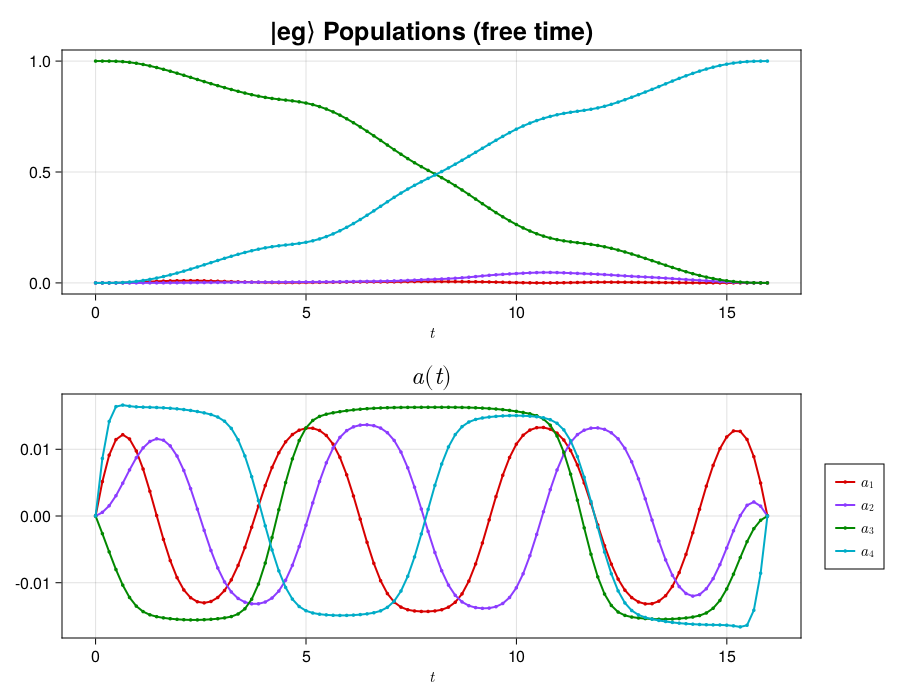

In [19]:
transformation = OrderedDict(
   :Ũ⃗ => [x -> populations(iso_vec_to_operator(x)[:, 3])]
)
titles = OrderedDict(:Ũ⃗ => ["|eg⟩ Populations (free time)"])
plot(prob.trajectory, [:a]; transformations=transformation, transformation_titles=titles, ignored_labels=[:Ũ⃗], res=(900, 700))

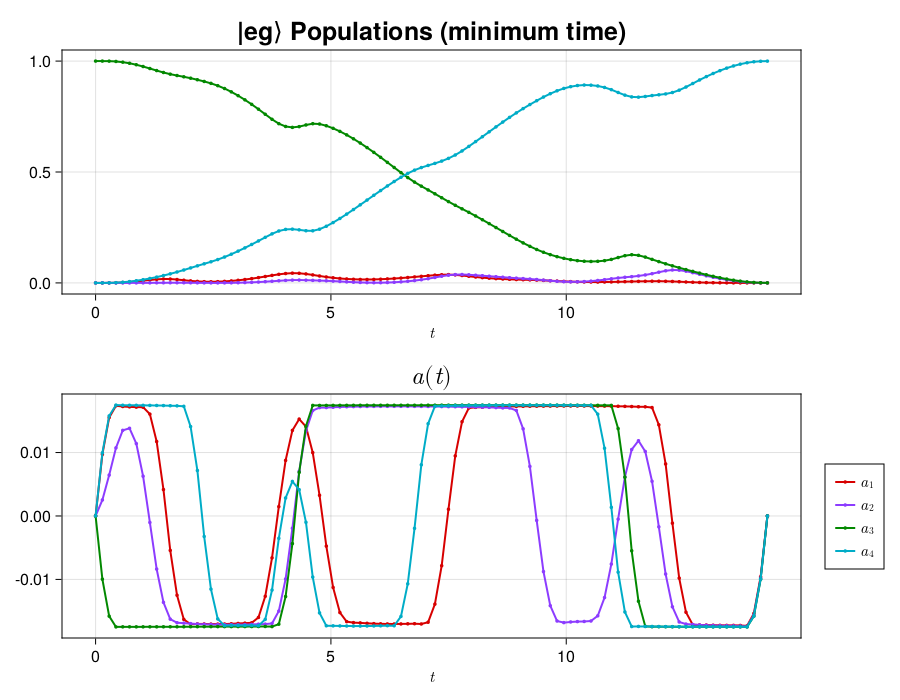

In [20]:
transformation = OrderedDict(
   :Ũ⃗ => [x -> populations(iso_vec_to_operator(x)[:, 3])]
)
titles = OrderedDict(:Ũ⃗ => ["|eg⟩ Populations (minimum time)"])
plot(mintime_prob.trajectory, [:a]; transformations=transformation, transformation_titles=titles, ignored_labels=[:Ũ⃗], res=(900, 700))

In [21]:
original_duration = get_times(prob.trajectory)[end]
mintime_duration = get_times(mintime_prob.trajectory)[end]
println("Original Duration: $original_duration ns")
println("Minimum Duration:  $mintime_duration ns")

Original Duration: 15.964238822994437 ns
Minimum Duration:  14.274237182086514 ns
